In [1]:
import sys
sys.path.append('../src/')
import model as ez
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import tqdm
import h5py

In [2]:
plt.style.use('default')
# plt.style.use('dark_background')
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.serif"] = "Times New Roman"

# Collision-based model of sediment transport
A lattice model meant to replicate the statistics of sediment transport close to the threshold of motion, in the regime where collisions are thought to dominate.

There are two settings: 
    
   1. Nonperiodic setting, meant to replicate the laboratory flume experiments. In this setting one sets the input flux.
   2. Periodic boundary conditions. In this setting one sets the probability of random entrainment by the fluid.
   
This is still a work in progress and a more comprehensive tutorial will be created once the model is finished. That said, if you have any questions, feel free to email me at: santib@mit.edu

## 1) Nonperiodic, flume-like setup

In [21]:
# Set parameters

# Sets how likely an entrained grain is to entrain a neighboring grain
c_0 = 0.2  

# Szie of domain
Nx = 100
Ny = 20

# Average lattice sites hopped over by grain in motion
skipmax = 2

# Main input parameter: number of grains dropped at one end of the domain per time step.
q_in = 0.5

In [22]:
# Initialize
set_q = ez.set_q(Nx,Ny,q_in,c_0,skipmax)

In [23]:
# For collecting some data
bed_activity = []
q_outs = []
beds = []

In [24]:
# Quick estimate of how many time steps to take to build the bed
slope_c = np.sqrt((1/(9*set_q.c_0**2))-1)
N = (set_q.Nx*slope_c)*set_q.Nx*0.5*set_q.Ny #total number of beads in 'expected' bed
T = N/q_in # total number of time-steps necessary to build that bed is going to N (particles)/q_in (particles/time step)
T = int(2*T) # so that we build the bed and also have a reasonable steady state

If restarting from a previous run, you can load the state:

In [25]:
# Load data:
# set_q.load_data("./ez_data_Nx_100_Ny_20_qin_0d5_c0_0d2_skip_2_2020-10-05.p")

In [26]:
for i in tqdm.tqdm(range(T)):
    # Calculate
    bed_activity.append(set_q.bed_activity())  # Fraction of sites that are active
    q_outs.append(set_q.q_out)  # How many grains left the domain in that time step
    if (i%(int(T/10.)))==0: # Have 10 bed snapshots per run
        beds.append(np.mean(set_q.z,axis=0))
    
    # Take a step in the model
    set_q.step()

100%|█████████████████████████████████████████████████████████████████████████| 533333/533333 [10:22<00:00, 857.33it/s]


Save the current state:

In [28]:
# Export data.
# Only input the function takes is the directory to which you want to save the data.
set_q.export_data('./')

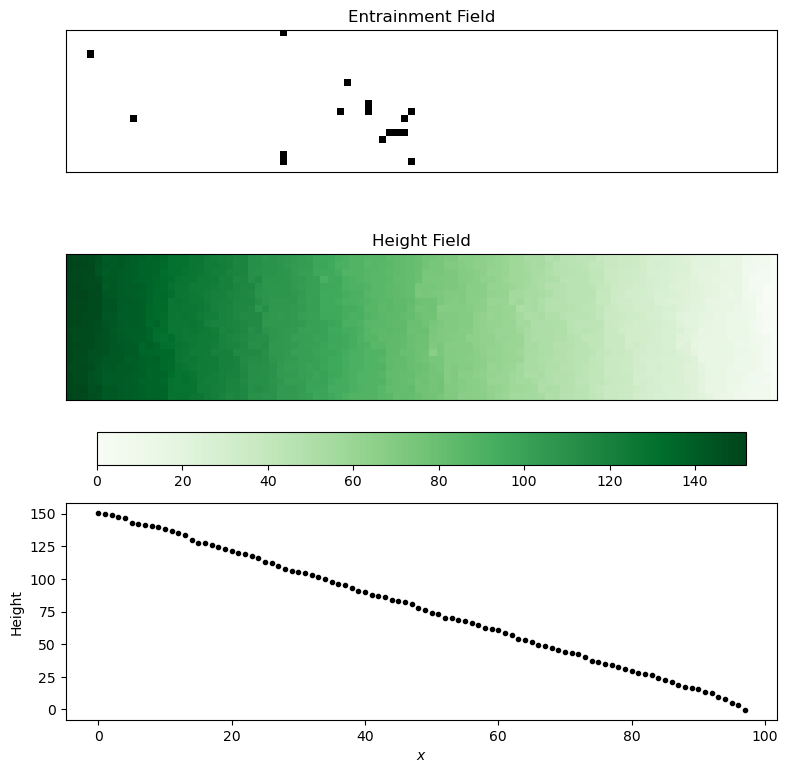

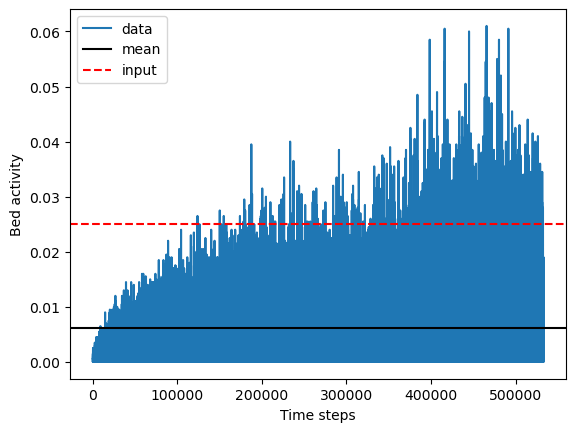

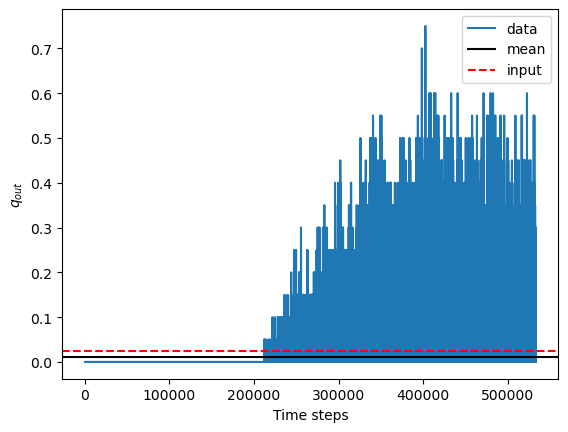

In [27]:
# Quick and easy plotting of the current state
set_q.plot_min()#save=True)

# Plot the other time series you were keeping track of
plt.plot(bed_activity,label ="data")
plt.axhline(y=np.mean(bed_activity),c='k',ls='-',label = "mean")
plt.axhline(y=q_in/float(Ny),c='r',ls='--',label = "input")
plt.xlabel("Time steps")
plt.ylabel("Bed activity")
plt.legend()
plt.show()

plt.plot(np.array(q_outs)/float(set_q.Ny),label ="data")
plt.axhline(y=np.mean(np.array(q_outs)/float(set_q.Ny)),c='k',ls='-',label = "mean")
plt.axhline(y=q_in/float(set_q.Ny),c='r',ls='--',label = "input")
plt.xlabel("Time steps")
plt.ylabel(r"$q_{out}$")
plt.legend()
plt.show()

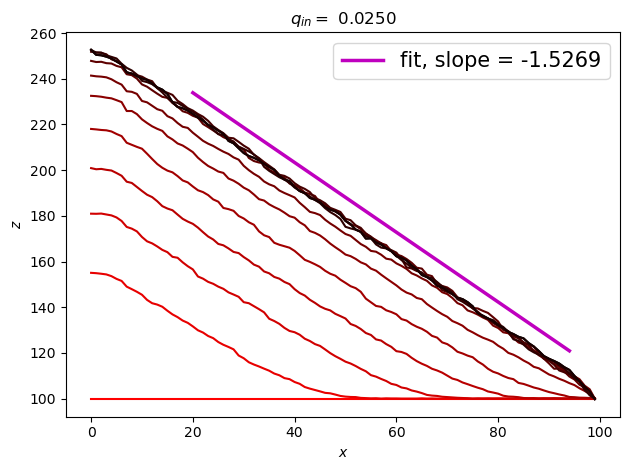

In [29]:
x = np.arange(Nx)
plt.plot(np.mean(set_q.z,axis=0),'k')
for ii,bed in enumerate(beds):
    plt.plot(bed,color = ((len(beds)-ii)/float(len(beds)),0,0,1))
m,b = np.polyfit(x[20:],np.mean(set_q.z,axis=0)[20:],1)
plt.plot(x[20:-5],m*x[20:-5]+b+10,'-m',lw=2.5,label = 'fit, slope = %.4f' % m)
plt.xlabel(r"$x$")
plt.ylabel(r"$z$")
plt.title(r'$q_{in}= $ %.4f' % float(q_in/Ny))
plt.legend(fontsize=15)
plt.tight_layout()
# plt.savefig('./Figures/bed_height_tseries_qin_0d005.png',dpi=200,bbox_inches='tight')

Make a movie!

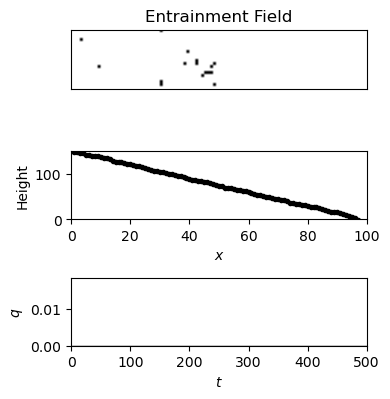

In [30]:
set_q.make_movie(500,20,'./',name_add='_test')

## 2) Periodic

In [11]:
# Set parameters

# Sets how likely an entrained grain is to entrain a neighboring grain
c_0 = 0.2  

# Szie of domain
Nx = 100
Ny = 20

# Average lattice sites hopped over by grain in motion
skipmax = 2

# Main input parameter: fraction of grains randomly entrained by fluid each time step.
f = 10./(Nx*Ny)

In [12]:
# Initialize
set_f = ez.set_f(Nx,Ny,f,c_0,skipmax,initial=f)

In [13]:
# For collecting some data
bed_activity = []
beds = []

For this setting, we initialize with a bed already:

In [14]:
# Choose slope
slope_c = np.sqrt((1/(9*set_f.c_0**2))-1)

# Build the bed using the built-in function. Input is the slope of the bed only.
set_f.z = set_f.build_bed(slope_c*1.1)

If restarting from a previous run, you can load the state:

In [8]:
# Load data:
# set_f.load_data("./ez_data_Nx_100_Ny_20_f_0d005_c0_0d2_skip_2_2020-10-05.p")

In [15]:
T = 10000
for i in tqdm.tqdm(range(T)):
    # Calculate
    bed_activity.append(set_f.bed_activity())  # Fraction of sites that are active
    if (i%(int(T/10.)))==0: # Have 10 bed snapshots per run
        beds.append(np.mean(set_f.z,axis=0))
    
    # Take a step in the model
    set_f.step()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:14<00:00, 74.12it/s]


Save the current state:

In [17]:
# Export data.
# Only input the function takes is the directory to which you want to save the data.
set_f.export_data('./')

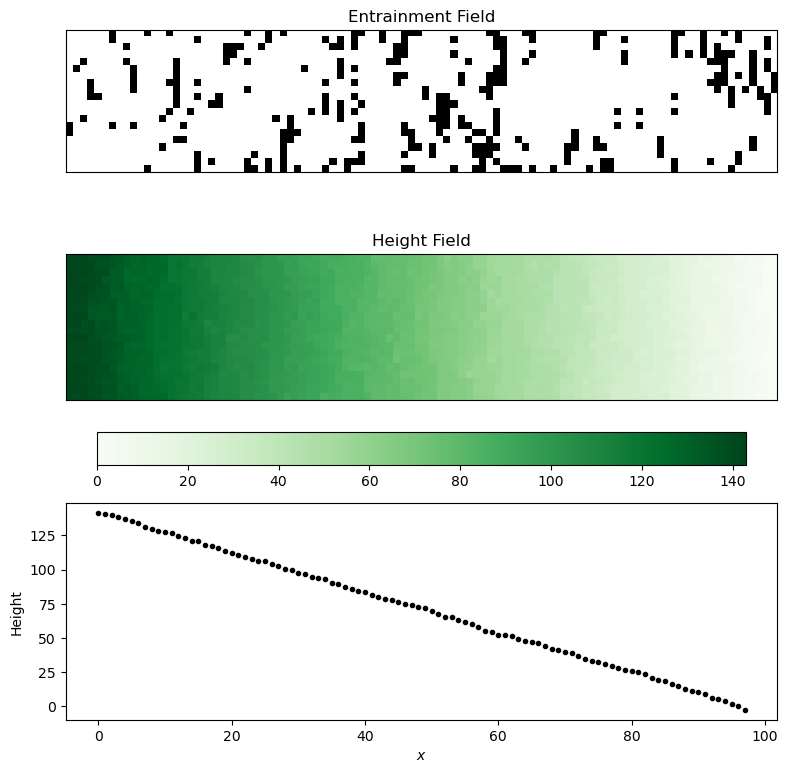

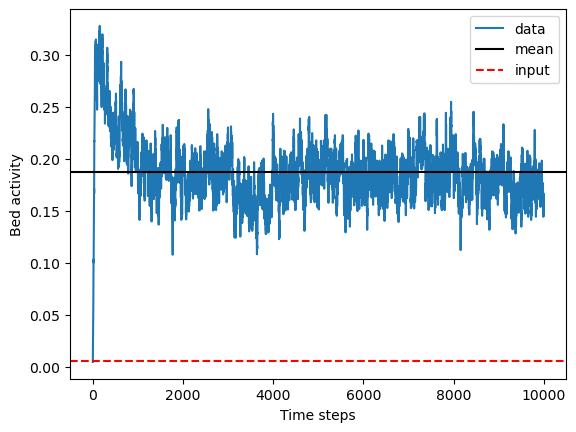

In [19]:
# Quick and easy plotting of the current state
set_f.plot_min()#save=True)

# Plot the other time series you were keeping track of
plt.plot(bed_activity,label ="data")
plt.axhline(y=np.mean(bed_activity),c='k',ls='-',label = "mean")
plt.axhline(y=f,c='r',ls='--',label = "input")
plt.xlabel("Time steps")
plt.ylabel("Bed activity")
plt.legend()
plt.show()

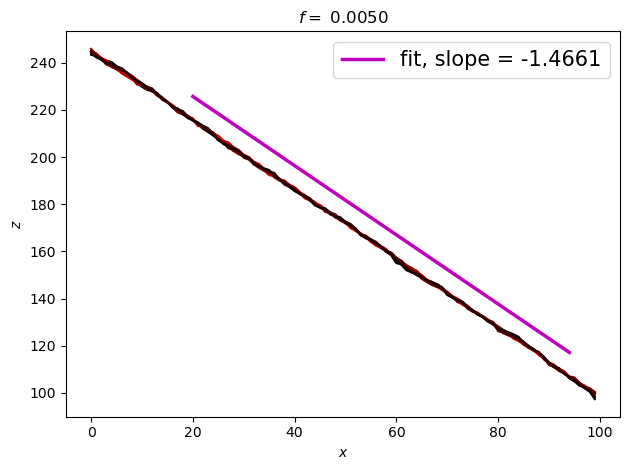

In [20]:
x = np.arange(Nx)
plt.plot(np.mean(set_f.z,axis=0),'k')
for ii,bed in enumerate(beds):
    plt.plot(bed,color = ((len(beds)-ii)/float(len(beds)),0,0,1))
m,b = np.polyfit(x[20:],np.mean(set_f.z,axis=0)[20:],1)
plt.plot(x[20:-5],m*x[20:-5]+b+10,'-m',lw=2.5,label = 'fit, slope = %.4f' % m)
plt.xlabel(r"$x$")
plt.ylabel(r"$z$")
plt.title(r'$f= $ %.4f' % float(f))
plt.legend(fontsize=15)
plt.tight_layout()
# plt.savefig('./Figures/bed_height_tseries_qin_0d005.png',dpi=200,bbox_inches='tight')

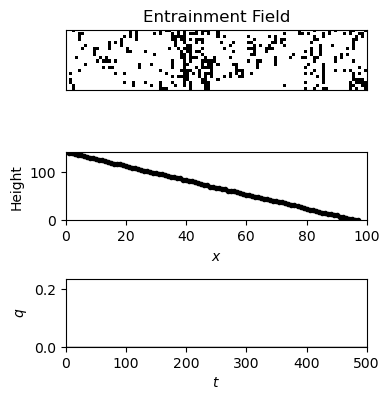

In [10]:
set_f.make_movie(500,20,'./',name_add='_test')